In [4]:
from arctic import CHUNK_STORE, Arctic
a = Arctic('localhost')
US_Equity = a['Alpaca_Equity_daily']
US_Equity2 = a['Alpaca_Equity_minute_new']
US_Futures = a['Quandl_Futures_daily']
a.list_libraries()

ModuleNotFoundError: No module named 'arctic'

In [5]:
import datetime, requests, os, json 
import pandas as pd 
import numpy as np

## Quandl API 
import quandl 
quandl.ApiConfig.api_key = os.environ.get('QUANDL', 'He76uGCS7L-7s3dFZdpq')

## Alapca API 
Alapca_API_key = os.environ.get('APCA_API_KEY_ID', 'PKU6K5NE2E4VBKSSJ0TR')
Alapca_API_secret_key = os.environ.get('APCA_API_SECRET_KEY', '3kLHmYOR2Gj0LoFaANBnTqw3wObLkFZSsqZfguXI')

## Alphavantage 
Alphavantage_API_keys = ['GNGP1GQIO85ZWC6','BFF8HXURRGSI4YH2']

In [6]:
def download_quandl_futures(symbol, startdate='1955-01-01', enddate=datetime.date.today()):
    '''Returned Log price data from Quandl Futures with date as index.'''
    price_df = quandl.get(symbol, start_date=startdate, end_date=enddate)
    
    if 'Last' in price_df.columns:
        price_df['Close'] = price_df['Last']    
    if 'Settle' in price_df.columns:
        price_df['Close'] = price_df['Settle']
    if 'Total Volume' in price_df.columns:
        price_df['Volume'] = price_df['Total Volume']
    if 'Prev. Day Open Interest' in price_df.columns:
        price_df['Open Interest'] = price_df['Prev. Day Open Interest']
    if 'Previous Day Open Interest' in price_df.columns:
        price_df['Open Interest'] = price_df['Previous Day Open Interest']
    if 'O.I.' in price_df.columns:
        price_df['Open Interest'] = price_df['O.I.']
    
    price_df = price_df[['Open','High','Low','Close','Volume','Open Interest']]
    price_df.columns = ['Open','High','Low','Close','Volume','Open Interest']
    logdf = np.log(price_df) - np.log(price_df).shift(1)
    logdf.index.name = 'Date'
    logdf['date'] = logdf.index
    return logdf.dropna()

In [7]:
def download_quandl_symbols():
    url = 'https://www.quandl.com/api/v3/databases/CHRIS/metadata?api_key={}'.format(quandl.ApiConfig.api_key)
    df = pd.read_csv(url,compression='zip')
    df['from_date'] = pd.to_datetime(df['from_date'])
    df['to_date'] = pd.to_datetime(df['to_date'])
    df['exchange'] = df['code'].str.split('_',expand=True)[0]
    selected_exchanges = ['CME','ICE', 'EUREX', 'LIFFE', 'SHFE', 'CBOE']
    df = df[ (df['to_date'] > datetime.datetime.now()-datetime.timedelta(days=14)) 
            & (df['from_date'] < datetime.datetime.now()-datetime.timedelta(days=7300))
            & df['exchange'].isin(selected_exchanges) ]
    df['code'] = 'CHRIS/' + df['code']
    return df.sort_values('from_date')

In [8]:
download_quandl_futures('CHRIS/CME_ES1').set_index('date')

AuthenticationError: (Status 400) (Quandl Error QEAx01) We could not recognize your API key. Please check your API key and try again.

In [9]:
quandl_syms = download_quandl_symbols().sort_values('from_date').set_index('code')

HTTPError: HTTP Error 400: Bad Request

In [478]:
set(quandl_syms.index) - set(US_Futures.list_symbols())

{'CHRIS/LIFFE_FCE2', 'CHRIS/LIFFE_FCE3'}

In [63]:
## Download Alpaca price data 

def download_alpaca_data(ticker, timeframe='1D', start='2007-12-31T21:30:00-04:00', end=datetime.datetime.now()):
    '''Returned Price data from Quandl Futures with date as index.'''
    headers = {
    'APCA-API-KEY-ID' : Alapca_API_key,
    'APCA-API-SECRET-KEY': Alapca_API_secret_key,
    }
    response = requests.get('https://data.alpaca.markets/v1/bars/{}?symbols={}&start={}&end={}'.format(timeframe,ticker,start,end),headers=headers)
    df = pd.DataFrame(json.loads(response.text)[ticker])
    if timeframe == '1D':
        df.index = [x.replace(hour=0,minute=0) for x in pd.to_datetime(df['t'],unit='s')]
        df.index.name = 'Date'
        df.columns = ['date','Open','High','Low','Close','Volume']
    else:
        df.index = [x for x in pd.to_datetime(df['t'],unit='s')]
        df.index.name = 'Datetime'
        df.columns = ['date','Open','High','Low','Close','Volume']
    df.drop('date',axis=1,inplace=True)
    logdf = np.log(df) - np.log(df).shift(1)
    logdf['date'] = logdf.index
    #return logdf.dropna()
    return df

In [6]:
def download_alpaca_assets():
    url = 'https://paper-api.alpaca.markets/v2/assets'
    headers = {
    'APCA-API-KEY-ID' : Alapca_API_key,
    'APCA-API-SECRET-KEY': Alapca_API_secret_key,
    }
    response = requests.get(url,headers=headers)
    df = pd.DataFrame(response.json())
    valid = df[(df['shortable']) ]
    return valid

In [64]:
download_alpaca_assets()

,id,class,exchange,symbol,name,status,tradable,marginable,shortable,easy_to_borrow
0,e5c79337-c1ea-49bf-954e-d9be948d6bf3,us_equity,ARCA,AAAU,Perth Mint Physical Gold ETF (Trust),active,True,True,True,True
6,54909c5f-c74f-47e8-8684-37f80bf73e9a,us_equity,AMEX,AAMC,Altisource Asset Mgmt Corp,active,True,True,True,True
9,d3ce6de3-13f1-4941-94e9-f9f54174e448,us_equity,NYSE,ACC,"American Campus Communities, Inc.",active,True,True,True,True
10,681115d1-0667-442c-aa0b-c46e79ec5424,us_equity,NYSE,ACCO,Acco Brands Corporation,active,True,True,True,True
12,ca05c7af-bccb-4818-9c4f-3d1947b04cd9,us_equity,NYSE,ACEL,"Accel Entertainment, Inc.",active,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
10270,e32589a7-fcc4-45ac-84d6-57d366fc04ce,us_equity,ARCA,BOND,PIMCO Active Bond Exchange-Traded Fund,active,True,True,True,True
10271,57c36644-876b-437c-b913-3cdb58b18fd3,us_equity,NYSE,GE,General Electric Company,active,True,True,True,True
10277,fd03066c-16d8-4eff-8c72-16ce1c44e38d,us_equity,NYSE,VALE,VALE S.A.,active,True,True,True,True
10279,b0b6dd9d-8b9b-48a9-ba46-b9d54906e415,us_equity,NASDAQ,AAPL,Apple Inc. Common Stock,active,True,True,True,True


In [67]:
differences = set(download_alpaca_assets()['symbol']) - set(US_Equity.list_symbols())

In [69]:
len(differences)

1194

In [168]:
## Download Alphavantage data 

def download_alphavantage_data(ticker='QQQ',route='TIME_SERIES_DAILY_ADJUSTED',API_key=''):
    df = pd.read_csv('https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&datatype=csv&outputsize=full'.format(route,ticker,API_key))
    logdf = df.copy()
    logdf['Open'] = logdf['open'] / logdf['close']
    logdf['High'] = logdf['high'] / logdf['close']
    logdf['Low'] = logdf['low'] / logdf['close']
    logdf['Close'] = np.log(df['adjusted_close']) - np.log(df['adjusted_close'].shift(-1))
    logdf['Volume'] = np.log(df['volume']) - np.log(df['volume'].shift(-1))
    logdf['date'] = pd.to_datetime(df['timestamp'])
    logdf = logdf.dropna().sort_values('date')[['date','Open','High','Low','Close','Volume']]
    logdf.index = logdf['date']
    logdf.index.name = 'Date'
    data = dict()
    data['raw'] = df
    data['log'] = logdf 
    
    return data

In [169]:
df = download_alphavantage_data(ticker='TSLA',API_key=Alphavantage_API_keys[0])['log']

In [170]:
a.delete_library('Alphavnatage_Equity_daily')
a.initialize_library('Alphavnatage_Equity_daily', lib_type=CHUNK_STORE)
Alpha = a['Alphavnatage_Equity_daily']

In [174]:
Alpha.update('TSLA', df, chunk_range=df.index, upsert=True)
Alpha.update('TSLA', df, chunk_range=df.index, upsert=True)
Alpha.update('TSLA', df, chunk_range=df.index, upsert=True)

In [176]:
newdf = Alpha.read('TSLA')

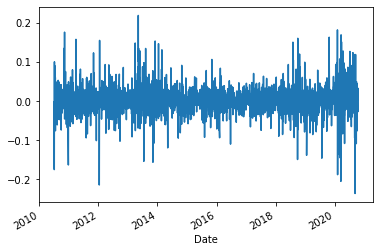

In [179]:
newdf['Close'].plot()

In [180]:
newdf

,date,Open,High,Low,Close,Volume
Date,,,,,,
2010-06-30,2010-06-30,1.082249,1.276509,0.977759,-0.002515,-0.087904
2010-07-01,2010-07-01,1.138434,1.180328,0.923042,-0.081723,-0.737735
2010-07-02,2010-07-02,1.197917,1.203125,0.974479,-0.134312,-0.469410
2010-07-06,2010-07-06,1.241465,1.241465,0.982619,-0.175470,0.289699
2010-07-07,2010-07-07,1.037975,1.052532,0.948101,-0.019430,0.007949
...,...,...,...,...,...,...
2020-10-12,2020-10-12,0.999322,1.014560,0.991589,0.018944,0.293463
2020-10-13,2020-10-13,0.992612,1.005015,0.977499,0.009787,-0.118286
2020-10-14,2020-10-14,0.975027,1.009972,0.969759,0.032273,0.332241


EEM and SLV has extreme price movement before 2009 need to find a better source? 
TSLA is not split adjusted

In [77]:
df = download_alpaca_data('TSLA',)

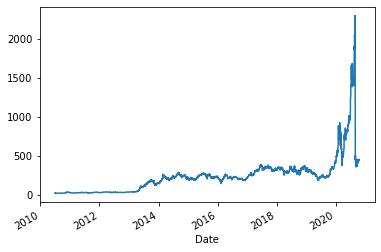

In [78]:
df['Open'].plot()

In [ ]:
from arctic import CHUNK_STORE, Arctic

In [ ]:
a = Arctic('localhost')
a.initialize_library('Sample', lib_type=CHUNK_STORE)
Sample = a['Sample']
df1 = download_alpaca_data('AAPL')

In [ ]:
Sample.update('AAPL', df1, chunk_range=df1.index, upsert=True)

In [ ]:
Sample.list_symbols()

In [ ]:
Sample.read('AAPL').set_index('date').columns

In [441]:
a.delete_library('Sample')

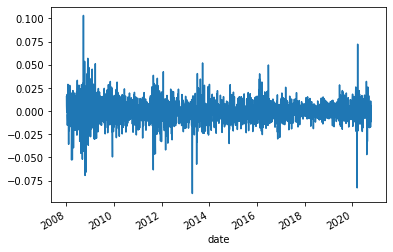

In [52]:
US_Equity.read('GLD').set_index('date')['Open'].plot()

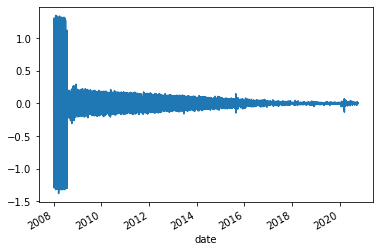

In [54]:
US_Equity.read('EEM').set_index('date')['Open'].plot()

In [187]:
selected_symbols=[ u for u in US_Futures.list_symbols() if u[-1] == '1']
selected_symbols

['CHRIS/CME_AD1',
 'CHRIS/CME_B31',
 'CHRIS/CME_BO1',
 'CHRIS/CME_BP1',
 'CHRIS/CME_C1',
 'CHRIS/CME_CD1',
 'CHRIS/CME_CL1',
 'CHRIS/CME_CL11',
 'CHRIS/CME_CL21',
 'CHRIS/CME_CL31',
 'CHRIS/CME_EC1',
 'CHRIS/CME_ED1',
 'CHRIS/CME_ED11',
 'CHRIS/CME_ED21',
 'CHRIS/CME_ED31',
 'CHRIS/CME_ES1',
 'CHRIS/CME_FC1',
 'CHRIS/CME_FF1',
 'CHRIS/CME_FF11',
 'CHRIS/CME_FF21',
 'CHRIS/CME_FV1',
 'CHRIS/CME_GC1',
 'CHRIS/CME_HG1',
 'CHRIS/CME_HG11',
 'CHRIS/CME_HO1',
 'CHRIS/CME_HO11',
 'CHRIS/CME_JY1',
 'CHRIS/CME_KW1',
 'CHRIS/CME_LB1',
 'CHRIS/CME_LC1',
 'CHRIS/CME_LN1',
 'CHRIS/CME_MD1',
 'CHRIS/CME_MP1',
 'CHRIS/CME_NG1',
 'CHRIS/CME_NG11',
 'CHRIS/CME_NG21',
 'CHRIS/CME_NG31',
 'CHRIS/CME_NK1',
 'CHRIS/CME_NQ1',
 'CHRIS/CME_O1',
 'CHRIS/CME_PA1',
 'CHRIS/CME_PL1',
 'CHRIS/CME_RR1',
 'CHRIS/CME_S1',
 'CHRIS/CME_SF1',
 'CHRIS/CME_SI1',
 'CHRIS/CME_SM1',
 'CHRIS/CME_SP1',
 'CHRIS/CME_TY1',
 'CHRIS/CME_US1',
 'CHRIS/CME_W1',
 'CHRIS/EUREX_FGBM1',
 'CHRIS/ICE_B1',
 'CHRIS/ICE_B11',
 'CHRIS/ICE_B21'

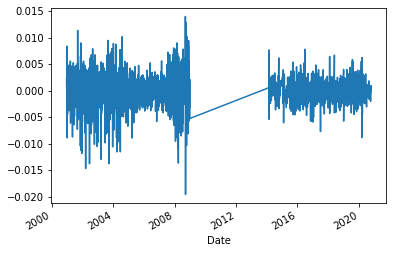

In [188]:
US_Futures.read('CHRIS/CME_FV1')['Close'].plot()

In [391]:
US_Equity2.read('V')

,Open,High,Low,Close,Volume,date
Datetime,,,,,,
2019-10-15 13:31:00,-0.001798,-0.001798,-0.001236,-0.001405,-0.710496,2019-10-15 13:31:00
2019-10-15 13:32:00,0.000731,0.000731,0.000731,0.000731,-0.423120,2019-10-15 13:32:00
2019-10-15 13:33:00,-0.000562,-0.000056,-0.000562,-0.000506,1.955677,2019-10-15 13:33:00
2019-10-15 13:34:00,-0.000112,0.002021,-0.000112,0.001404,0.985140,2019-10-15 13:34:00
2019-10-15 13:35:00,0.001236,-0.001122,0.000731,-0.000056,-0.812040,2019-10-15 13:35:00
...,...,...,...,...,...,...
2020-10-13 18:33:00,0.000417,0.001717,0.000515,0.001815,0.352108,2020-10-13 18:33:00
2020-10-13 18:34:00,0.001202,-0.000098,0.000858,-0.000441,-0.388742,2020-10-13 18:34:00
2020-10-13 18:35:00,-0.000613,-0.000613,-0.000270,-0.000270,0.363986,2020-10-13 18:35:00


In [ ]:
df1 = US_Equity.read('GS').set_index('date')
df2 = US_Equity.read('AAPL').set_index('date')

In [ ]:
df1.merge(df2,how='outer',on='date')

In [ ]:
merged_df = df1.merge(df2,how='outer',on='date').merge(df2,how='outer',on='date').sort_values(by='date').fillna(0)

In [ ]:
price_tensor = np.zeros(shape=(merged_df.shape[0],5,int(merged_df.shape[1]/5)))

In [ ]:
price_tensor.shape

In [ ]:
for count in range(int(merged_df.shape[1]/5)):
    price_tensor[:,:,count] = merged_df.values[:,5*count:5*count+5]

In [4]:
import pandas as pd
import numpy as np



In [5]:
def create_features(all_data_df):

    all_data_df['dollarvolume'] = all_data_df['volume'] * all_data_df['close']
    all_data_df['dollarvolume_ratio'] = all_data_df['dollarvolume'] / all_data_df['dollarvolume'].shift(1)
    all_data_df['volume_total_adj'] = all_data_df['volume_total'] / all_data_df['cfadj'].shift(1)
    all_data_df['OI_total_adj'] = all_data_df['OI_total'] / all_data_df['cfadj'].shift(1)
    all_data_df['optionvolume_ratio'] = all_data_df['volume_total_adj'] / all_data_df['volume_total_adj'].shift(1)
    all_data_df['optionOI_ratio'] = all_data_df['OI_total_adj'] / all_data_df['OI_total_adj'].shift(1)

    # put call ratios 
    all_data_df['put_call_volume'] = all_data_df['volume_put'] / all_data_df['volume_call']
    all_data_df['put_call_OI'] = all_data_df['OI_put'] / all_data_df['OI_call'] 


    # intraday range 
    all_data_df['open_close'] = all_data_df['open'] / all_data_df['close']
    all_data_df['high_close'] = all_data_df['high'] / all_data_df['close']  
    all_data_df['low_close'] = all_data_df['low'] / all_data_df['close']  

    # returns 
    # Rolling calculations of the last 25 days for each stock uses data from other stocks which needs to be removed
    all_data_df['adjclose'] = all_data_df['close'] * all_data_df['cfret'] 
    all_data_df['logreturn'] = np.log(all_data_df['adjclose']) - np.log(all_data_df['adjclose'].shift(1))
    all_data_df['target_1'] = np.log(all_data_df['adjclose'].shift(-2)) - np.log(all_data_df['adjclose'].shift(-1))
    all_data_df['target_5'] = np.log(all_data_df['adjclose'].shift(-6)) - np.log(all_data_df['adjclose'].shift(-1))
    all_data_df['target_10'] = np.log(all_data_df['adjclose'].shift(-11)) - np.log(all_data_df['adjclose'].shift(-1))
    all_data_df['target_20'] = np.log(all_data_df['adjclose'].shift(-21)) - np.log(all_data_df['adjclose'].shift(-1))
    
    return all_data_df

In [23]:
df = pd.read_csv('csvdata/OM/2581610.csv')
df = create_features(df)
df.to_csv('csvdata/OM/2581610.csv',index=False)

In [24]:
df

,cusip,date,low,high,close,open,volume,cfadj,cfret,volume_total,...,low_close,adjclose,logreturn,target_1,target_2,target_3,day,target_5,target_10,target_20
0,2581610,1996-01-04,41.000,42.125,41.125,41.875,1491400.0,1.0,1.005422,2120.0,...,0.996960,41.347980,NaN,0.000000,0.018127,0.084722,0.0,-0.050010,0.044717,0.087519
1,2581610,1996-01-05,40.750,41.375,41.000,41.125,1223600.0,1.0,1.005422,1324.0,...,0.993902,41.222302,-0.003044,-0.015361,0.044717,0.087519,1.0,-0.056441,0.041797,0.104140
2,2581610,1996-01-08,41.000,41.250,41.000,41.000,303600.0,1.0,1.005422,446.0,...,1.000000,41.222302,0.000000,-0.034649,0.057158,0.119502,4.0,-0.018751,0.027483,0.119502
3,2581610,1996-01-09,40.375,41.375,40.375,41.250,1298500.0,1.0,1.005422,594.0,...,1.000000,40.593913,-0.015361,0.012739,0.062132,0.154151,5.0,0.034649,0.046957,0.162359
4,2581610,1996-01-10,38.750,40.250,39.000,40.125,2455000.0,1.0,1.005422,2624.0,...,0.993590,39.211458,-0.034649,-0.012739,0.034218,0.149620,6.0,0.055399,0.031155,0.181794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,2581610,2019-12-24,124.380,125.330,124.740,124.950,953540.0,3.0,4.701604,3483.0,...,0.997114,586.478083,0.002006,-0.001756,NaN,NaN,8755.0,NaN,NaN,NaN
6036,2581610,2019-12-26,124.530,125.437,125.410,124.980,1487824.0,3.0,4.701604,5445.0,...,0.992983,589.628158,0.005357,-0.007135,NaN,NaN,8757.0,NaN,NaN,NaN
6037,2581610,2019-12-27,125.110,125.970,125.190,125.840,1788623.0,3.0,4.701604,4921.0,...,0.999361,588.593805,-0.001756,0.001527,NaN,NaN,8758.0,NaN,NaN,NaN
6038,2581610,2019-12-30,124.180,125.460,124.300,125.200,2306455.0,3.0,4.701604,10125.0,...,0.999035,584.409377,-0.007135,NaN,NaN,NaN,8761.0,NaN,NaN,NaN
